In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ase.io import read, write, Trajectory
from glob import glob
from mace.calculators import MACECalculator
import sys
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from pathlib import Path
from ase.build.surface import mx2
from ase.optimize import BFGS
from ase.constraints import FixedLine

model_path = "/home/theory/phrrpq/Research_Data/quaternary_test/bilayer_models/MoWSSe_bi_radius_8_reduced_all_1_swa_800_run-123_swa.model"
calc=MACECalculator(model_paths=model_path, device="cuda", default_dtype="float64")

# --- Energy Computation Helper ---
def compute_adhesive_energy(atoms, tmdc1, tmdc2, use_mace=False):
    
    if use_mace:
        atoms.calc = calc
    energy = atoms.get_potential_energy()
    area = atoms.get_volume() / atoms.cell[2][2]
    adhesive_energy = 100 * (energy - mono_es[tmdc1] - mono_es[tmdc2]) / area
    return adhesive_energy

def passlog():
    pass

# --- Monolayer Energies ---
mono_es = {
    'MoS2': read('primitive/prim_MoS2.pwo').get_potential_energy(),
    'MoSe2': read('primitive/prim_MoSe2.pwo').get_potential_energy(),
    'WS2': read('primitive/prim_WS2.pwo').get_potential_energy(),
    'WSe2': read('primitive/prim_WSe2.pwo').get_potential_energy()
}

# --- Constants ---
LW = 0.3
MARKERSIZE = 3
FONT_SIZE = 7
plt.rcParams['font.size'] = FONT_SIZE

def plot_energy_curves(ax, ds, tmdc1, tmdc2, stacking, stacknames,foldername, path_fmt, skip_first=False):
    
    legend_elements = []
    for k in range(6):
        dft_energies = np.zeros(len(ds))
        mace_energies = np.zeros(len(ds))

        for l, d in enumerate(ds):
            filename = Path(path_fmt.format(foldername=foldername,
                                            tmdc1=tmdc1, tmdc2=tmdc2,
                                            stacking=stacking, idx=k+1,
                                            d=d))
        
            if not filename.exists():
                continue
            if filename.name == 'WSe2_WSe2_P1_d5.500.pwo':
                continue
                
            atoms = read(filename)
            dft_energies[l] = compute_adhesive_energy(atoms, tmdc1, tmdc2, use_mace=False)
            mace_energies[l] = compute_adhesive_energy(atoms, tmdc1, tmdc2, use_mace=True)

        if skip_first and tmdc1 == 'WSe2' and tmdc2 == 'WSe2' and stacking == 'P' and k == 0:
            x_vals, dft_y, mace_y = ds[1:], dft_energies[1:], mace_energies[1:]
        else:
            x_vals, dft_y, mace_y = ds, dft_energies, mace_energies

        solid = ax.plot(x_vals, dft_y, marker='o', markersize=MARKERSIZE-2, lw=LW)
        ax.plot(x_vals, mace_y, marker='x', linestyle='--',
                color=solid[0].get_color(), markerfacecolor='none',
                markersize=MARKERSIZE-1, lw=LW)
        label = stacknames[k + 1]
        legend_elements.append(Line2D([0], [0], color=solid[0].get_color(), label=label, lw=0.5))
        
    ax.set_ylim(-4.5, 3)
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(1))

    ax.text(0.98, 0.98, rf"{stacking}-{tmdc1[:-1]}$_2$/{tmdc2[:-1]}$_2$", transform=ax.transAxes,
    fontsize=FONT_SIZE + 4, ha='right', va='top')


    legend_loc = 'lower left' if 'Se' in tmdc1 else 'lower right'
    ax.legend(handles=legend_elements, fontsize=FONT_SIZE - 2.25, frameon=False, loc=legend_loc)

def add_fixed_line_constraints(atoms):
    from ase.constraints import FixedLine
    constraints = [FixedLine(i, direction=[0, 0, 1]) for i in range(len(atoms))]
    atoms.set_constraint(constraints)    

def relax_structure(atoms, calculator, fmax=0.001):
    atoms.calc = calculator
    dyn = BFGS(atoms)
    dyn.log = passlog
    dyn.run(fmax=fmax)

bilayers = [('MoS2','MoS2'),('WS2','WS2'),('MoS2','WS2'),
            ('MoSe2','MoSe2'),('WSe2','WSe2'),('MoSe2','WSe2')]


def get_stacking_minima(tmdc1, tmdc2, stacking, offsets, stack_labels, initial_d, foldername, tag='', test=False):
    
    for k, offset in enumerate(offsets):
        idx = k if stacking == 'P' else k + len(offsets)
        suffix = f"test{k+1}" if test else f"{k+1}"
        filename = f"{foldername}/{tmdc1}_{tmdc2}_{stacking}{suffix}_d{initial_d:.3f}.pwo"
        
        bilayer = read(filename)
        dft_es[idx]  = compute_adhesive_energy(bilayer, tmdc1, tmdc2)
        dft_ds[idx] = np.abs(bilayer[0].z-bilayer[3].z)
        
        add_fixed_line_constraints(bilayer)
        relax_structure(bilayer, calc)
        ml_es[idx] = compute_adhesive_energy(bilayer, tmdc1, tmdc2, calc)
        ml_ds[idx] = np.abs(bilayer[0].z-bilayer[3].z)
        print(f'{stack_labels[k+1]}    DFT_d:{dft_ds[idx]:.3f} ML_d:{ml_ds[idx]:.3f} '
              f'DFT_energy:{dft_es[idx]:.3f} ML_energy:{ml_es[idx]:.3f}')

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


# Plotting DFT vs MLIP adhesive energy densities as a function of interlayer d for different stackings included in training dataset

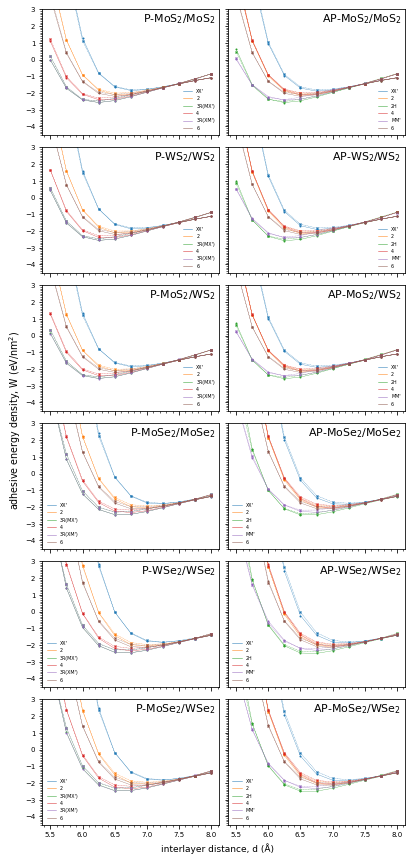

In [2]:
ds = np.linspace(5.5, 8, 11)
P_stacks = {1:"XX'", 2:"2", 3:"3R(MX')", 4:"4", 5:"3R(XM')", 6:"6"}
AP_stacks = {1:"XX'", 2:"2", 3:"2H", 4:"4", 5:"MM'", 6:"6"}
stacknames_list = [P_stacks, AP_stacks]

fig, axs = plt.subplots(6, 2, figsize=(6.5, 15))
foldername = 'aligned_train/'
for i, (tmdc1, tmdc2) in enumerate(bilayers):
    for j, stacking in enumerate(['P', 'AP']):
        stack_dict = stacknames_list[j]
        ax = axs[i][j]
        path_fmt = '{foldername}/{tmdc1}_{tmdc2}_{stacking}{idx}_d{d:0.3f}.pwo'
        plot_energy_curves(ax, ds, tmdc1, tmdc2, stacking, stack_dict, foldername, path_fmt, skip_first=True)

        if i != len(bilayers) - 1:
            ax.tick_params(labelbottom=False)
        if j != 0:
            ax.tick_params(labelleft=False)

plt.subplots_adjust(wspace=0.05, hspace=0.1)
fig.text(0.5, 0.1, r'interlayer distance, d (Å)', ha='center', fontsize=FONT_SIZE + 2)
fig.text(0.05, 0.5, 'adhesive energy density, W (eV/nm$^{2}$)', va='center', rotation='vertical', fontsize=FONT_SIZE + 2.5)

plt.savefig('energy_vs_d_dft_mace_train', facecolor='white', transparent=False, dpi=300,
            bbox_inches='tight', pad_inches=0.02)
plt.show()

# Plotting DFT vs MLIP adhesive energy densities as a function of interlayer d for random stackings created for testing

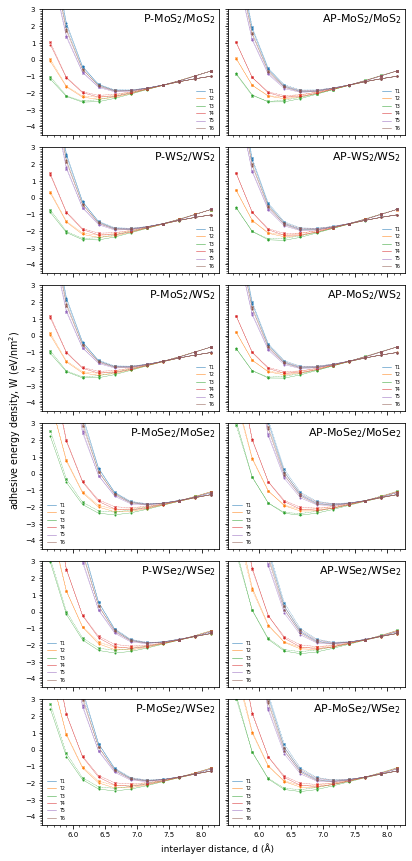

In [3]:
# --- System Setup ---
ds = np.linspace(5.5,8,11)+0.15
nstacks = 6
P_stacks = {1:"T1",2:"T2",3:"T3",4:"T4",5:"T5",6:"T6"}
AP_stacks = P_stacks
stacknames_list = [P_stacks, AP_stacks]

# --- Plotting ---
fig, axs = plt.subplots(6, 2, figsize=(6.5, 15))
foldername = 'aligned_test'
for i, (tmdc1, tmdc2) in enumerate(bilayers):
    for j, stacking in enumerate(['P', 'AP']):
        stack_dict = stacknames_list[j]
        ax = axs[i][j]
        path_fmt = '{foldername}/{tmdc1}_{tmdc2}_{stacking}test{idx}_d{d:0.3f}.pwo'
        plot_energy_curves(ax, ds, tmdc1, tmdc2, stacking, stack_dict,
                           foldername, path_fmt, skip_first=False)

        if i != len(bilayers) - 1:
            ax.tick_params(labelbottom=False)
        if j != 0:
            ax.tick_params(labelleft=False)

# --- Labels and Export ---
plt.subplots_adjust(wspace=0.05, hspace=0.1)
fig.text(0.5, 0.1, r'interlayer distance, d (Å)', ha='center', fontsize=FONT_SIZE + 2)
fig.text(0.05, 0.5, 'adhesive energy density, W (eV/nm$^{2}$)', va='center', rotation='vertical', fontsize=FONT_SIZE + 2.5)

plt.savefig('energy_vs_d_dft_mace_test', facecolor='white', transparent=False, dpi=300,
            bbox_inches='tight', pad_inches=0.02)
plt.show()

# Get minima for stackings in both train and test

In [4]:
P_offsets = np.array([[0,0],[0,1/(2*np.sqrt(3))],
            [0,-1/np.sqrt(3)],[0,1*np.sqrt(3)/2],
            [0,1/np.sqrt(3)],[-1/3,1/np.sqrt(3)]])

AP_offsets = np.array([[0,0],[0,-1/(2*np.sqrt(3))],
            [0,-1/np.sqrt(3)],[0,1/(2*np.sqrt(3))],
            [0,1/np.sqrt(3)],[-1/3,0]])

P_stacks = {1:"XX'",2:"2",3:"3R(MX')",4:"4",5:"3R(XM')",6:"f(d)"}
AP_stacks = {1:"XX'",2:"2",3:"2H",4:"4",5:"MM'",6:"f(d)"}

initial_d = 6.5
foldername = 'espresso_relax_train/'
for tmdc1, tmdc2 in bilayers:
    print(f"--- {tmdc1}/{tmdc2} ---")
    
    dft_ds, dft_es, ml_ds, ml_es = np.zeros(12), np.zeros(12), np.zeros(12), np.zeros(12)
    for j, stacking in enumerate(['P', 'AP']):
        print(f'Starting calculations for {stacking}-{tmdc1}/{tmdc2}')
        offsets = P_offsets if stacking == 'P' else AP_offsets
        stacks = P_stacks if stacking == 'P' else AP_stacks

        get_stacking_minima(tmdc1, tmdc2, stacking, offsets, stacks, initial_d, foldername)

    mae_es = np.mean(np.abs(dft_es - ml_es))
    mae_ds = np.mean(np.abs(dft_ds - ml_ds))
    print(f'{tmdc1}/{tmdc2} MAE_es: {mae_es:.3f} MAE_ds: {mae_ds:.3f}\n')

--- MoS2/MoS2 ---
Starting calculations for P-MoS2/MoS2
XX'    DFT_d:6.808 ML_d:6.807 DFT_energy:-1.854 ML_energy:-1.812
2    DFT_d:6.500 ML_d:6.571 DFT_energy:-2.101 ML_energy:-2.016
3R(MX')    DFT_d:6.237 ML_d:6.173 DFT_energy:-2.568 ML_energy:-2.492
4    DFT_d:6.378 ML_d:6.285 DFT_energy:-2.414 ML_energy:-2.309
3R(XM')    DFT_d:6.238 ML_d:6.173 DFT_energy:-2.568 ML_energy:-2.492
f(d)    DFT_d:6.501 ML_d:6.500 DFT_energy:-2.197 ML_energy:-2.087
Starting calculations for AP-MoS2/MoS2
XX'    DFT_d:6.782 ML_d:6.782 DFT_energy:-1.888 ML_energy:-1.820
2    DFT_d:6.500 ML_d:6.575 DFT_energy:-2.132 ML_energy:-2.036
2H    DFT_d:6.251 ML_d:6.189 DFT_energy:-2.572 ML_energy:-2.517
4    DFT_d:6.500 ML_d:6.555 DFT_energy:-2.095 ML_energy:-1.999
MM'    DFT_d:6.499 ML_d:6.195 DFT_energy:-2.375 ML_energy:-2.401
f(d)    DFT_d:6.501 ML_d:6.490 DFT_energy:-2.195 ML_energy:-2.087
MoS2/MoS2 MAE_es: 0.079 MAE_ds: 0.067

--- WS2/WS2 ---
Starting calculations for P-WS2/WS2
XX'    DFT_d:6.822 ML_d:6.836 DFT

In [5]:
np.random.seed(10)
test_offsets = np.random.uniform(-1,1,(6,2))
#print(test_offsets)
P_stacks = {1:"T1",2:"T2",3:"T3",4:"T4",5:"T5",6:"T6"}
AP_stacks = P_stacks
stacknames = [P_stacks, AP_stacks]

initial_d = 6.65
foldername = 'espresso_relax_test/'

for tmdc1, tmdc2 in bilayers:
    print(f"--- {tmdc1}/{tmdc2} ---")
    
    dft_ds, dft_es, ml_ds, ml_es = np.zeros(12), np.zeros(12), np.zeros(12), np.zeros(12)
    for j, stacking in enumerate(['P', 'AP']):
        print(f'Starting calculations for {stacking}-{tmdc1}/{tmdc2}')
        offsets = test_offsets
        stacks = P_stacks 
        get_stacking_minima(tmdc1, tmdc2, stacking, test_offsets, stacks, initial_d, foldername,test=True)

    mae_es = np.mean(np.abs(dft_es - ml_es))
    mae_ds = np.mean(np.abs(dft_ds - ml_ds))
    print(f'{tmdc1}/{tmdc2} MAE_es: {mae_es:.3f} MAE_ds: {mae_ds:.3f}\n')

--- MoS2/MoS2 ---
Starting calculations for P-MoS2/MoS2
T1    DFT_d:6.650 ML_d:6.778 DFT_energy:-1.857 ML_energy:-1.836
T2    DFT_d:6.350 ML_d:6.303 DFT_energy:-2.395 ML_energy:-2.285
T3    DFT_d:6.229 ML_d:6.175 DFT_energy:-2.563 ML_energy:-2.487
T4    DFT_d:6.650 ML_d:6.434 DFT_energy:-2.196 ML_energy:-2.143
T5    DFT_d:6.651 ML_d:6.734 DFT_energy:-1.930 ML_energy:-1.877
T6    DFT_d:6.650 ML_d:6.759 DFT_energy:-1.891 ML_energy:-1.854
Starting calculations for AP-MoS2/MoS2
T1    DFT_d:6.650 ML_d:6.763 DFT_energy:-1.899 ML_energy:-1.844
T2    DFT_d:6.357 ML_d:6.313 DFT_energy:-2.361 ML_energy:-2.273
T3    DFT_d:6.263 ML_d:6.192 DFT_energy:-2.568 ML_energy:-2.512
T4    DFT_d:6.650 ML_d:6.440 DFT_energy:-2.204 ML_energy:-2.158
T5    DFT_d:6.650 ML_d:6.724 DFT_energy:-1.962 ML_energy:-1.886
T6    DFT_d:6.650 ML_d:6.746 DFT_energy:-1.931 ML_energy:-1.863
MoS2/MoS2 MAE_es: 0.062 MAE_ds: 0.104

--- WS2/WS2 ---
Starting calculations for P-WS2/WS2
T1    DFT_d:6.651 ML_d:6.810 DFT_energy:-1.864